In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook
import os
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense,Activation,Flatten,Dropout,LSTM

import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import datetime
from datetime import date, timedelta
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-04-01', '%Y-%m-%d')

data_path = 'D:/universidad/universidad 4/TFG/recursos para el desarrollo/datos procesados/OD'

In [2]:
delta = e_date - i_date

target_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    target_days.append(day)

In [3]:
def read_OD_fn(source_type):
    ods = {}
    for date in tqdm_notebook(target_days):
        od_date= pd.read_csv(os.path.join(data_path, 'date_{}_OD_{}.csv'.format(source_type,date.strftime('%Y-%m-%d'))), 
                            index_col=0)
        ods[date] = od_date
    return ods

In [4]:
ine_ods = read_OD_fn('INE')

  0%|          | 0/81 [00:00<?, ?it/s]

# Serializar los datos

In [5]:
lista_ine1 = []
lista_ine2 = []
lista_ine3 = []
lista_ine4 = []
lista_ine5 = []

for date in tqdm_notebook(target_days):
    lista_ine1.append(ine_ods[date].loc['11CA','total'])
    lista_ine2.append(ine_ods[date].loc['33PO','total'])
    lista_ine3.append(ine_ods[date].loc['026V','total'])
    lista_ine4.append(ine_ods[date].loc['21BU','total'])
    lista_ine5.append(ine_ods[date].loc['49GI','total'])

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
df_ine1 = pd.DataFrame (lista_ine1, columns = ['Viajes'], index= target_days)
df_ine2 = pd.DataFrame (lista_ine2, columns = ['Viajes'], index= target_days)
df_ine3 = pd.DataFrame (lista_ine3, columns = ['Viajes'], index= target_days)
df_ine4 = pd.DataFrame (lista_ine4, columns = ['Viajes'], index= target_days)
df_ine5 = pd.DataFrame (lista_ine5, columns = ['Viajes'], index= target_days)

In [7]:
lista_ine = []

df = df_ine1 + df_ine2 + df_ine3 + df_ine4 + df_ine5

In [8]:
df.head()

,Viajes
2020-04-01,194
2020-04-02,183
2020-04-03,317
2020-04-04,177
2020-04-05,142


In [9]:
del ine_ods

# Visualización de datos

In [10]:
print(df.index.min())
print(df.index.max())

2020-04-01 00:00:00
2020-06-20 00:00:00


In [11]:
print(len(df['2020']))

81


In [12]:
df.describe()

,Viajes
count,81.000000
mean,366.592593
std,108.663446
min,110.000000
25%,303.000000
50%,390.000000
75%,433.000000
max,614.000000


In [13]:
meses = df.resample('M').mean()
meses

,Viajes
2020-04-30,276.233333
2020-05-31,402.096774
2020-06-30,447.100000


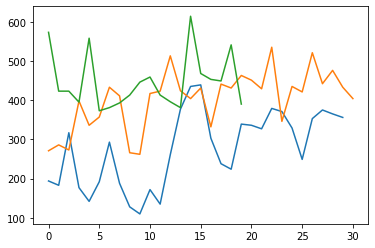

In [14]:
abril = df['2020-04-01':'2020-04-30']
plt.plot(abril.values)
mayo = df['2020-05-01':'2020-05-31']
plt.plot(mayo.values)
junio = df['2020-06-01':'2020-06-20']
plt.plot(junio.values)

# Preprocesado de datos

In [15]:
dataset = df.values
dataset = dataset.astype('float32')

In [16]:
# normalizamos el conjunto de datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# Dividimos los datos en sets de entrenamiento y validacion

In [17]:
#dividimos nuestros valores entre sets de entrenamiento y de test
n_train_days = 60
train = dataset[:n_train_days, :]
test = dataset[n_train_days:, :]

print(len(train), len(test))

60 21


In [18]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos
def create_dataset(dataset, look_back=1):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back, 0])
  return np.array(dataX), np.array(dataY)

In [19]:
# dividimos en entradas y salidas
look_back = 7

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

print(len(trainX), len(testY))

53 14


In [20]:
print(trainX)

[[0.16666667 0.14484127 0.41071433 0.13293652 0.06349207 0.16269843
  0.36309528]
 [0.14484127 0.41071433 0.13293652 0.06349207 0.16269843 0.36309528
  0.1547619 ]
 [0.41071433 0.13293652 0.06349207 0.16269843 0.36309528 0.1547619
  0.03571428]
 [0.13293652 0.06349207 0.16269843 0.36309528 0.1547619  0.03571428
  0.        ]
 [0.06349207 0.16269843 0.36309528 0.1547619  0.03571428 0.
  0.12301587]
 [0.16269843 0.36309528 0.1547619  0.03571428 0.         0.12301587
  0.04960318]
 [0.36309528 0.1547619  0.03571428 0.         0.12301587 0.04960318
  0.29960322]
 [0.1547619  0.03571428 0.         0.12301587 0.04960318 0.29960322
  0.52976197]
 [0.03571428 0.         0.12301587 0.04960318 0.29960322 0.52976197
  0.6448413 ]
 [0.         0.12301587 0.04960318 0.29960322 0.52976197 0.6448413
  0.65277785]
 [0.12301587 0.04960318 0.29960322 0.52976197 0.6448413  0.65277785
  0.38293654]
 [0.04960318 0.29960322 0.52976197 0.6448413  0.65277785 0.38293654
  0.25396824]
 [0.29960322 0.52976197 0.

In [21]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [22]:
print(trainX)

[[[0.16666667]
  [0.14484127]
  [0.41071433]
  [0.13293652]
  [0.06349207]
  [0.16269843]
  [0.36309528]]

 [[0.14484127]
  [0.41071433]
  [0.13293652]
  [0.06349207]
  [0.16269843]
  [0.36309528]
  [0.1547619 ]]

 [[0.41071433]
  [0.13293652]
  [0.06349207]
  [0.16269843]
  [0.36309528]
  [0.1547619 ]
  [0.03571428]]

 [[0.13293652]
  [0.06349207]
  [0.16269843]
  [0.36309528]
  [0.1547619 ]
  [0.03571428]
  [0.        ]]

 [[0.06349207]
  [0.16269843]
  [0.36309528]
  [0.1547619 ]
  [0.03571428]
  [0.        ]
  [0.12301587]]

 [[0.16269843]
  [0.36309528]
  [0.1547619 ]
  [0.03571428]
  [0.        ]
  [0.12301587]
  [0.04960318]]

 [[0.36309528]
  [0.1547619 ]
  [0.03571428]
  [0.        ]
  [0.12301587]
  [0.04960318]
  [0.29960322]]

 [[0.1547619 ]
  [0.03571428]
  [0.        ]
  [0.12301587]
  [0.04960318]
  [0.29960322]
  [0.52976197]]

 [[0.03571428]
  [0.        ]
  [0.12301587]
  [0.04960318]
  [0.29960322]
  [0.52976197]
  [0.6448413 ]]

 [[0.        ]
  [0.12301587]
  [0.04

In [23]:
print(trainY)

[0.1547619  0.03571428 0.         0.12301587 0.04960318 0.29960322
 0.52976197 0.6448413  0.65277785 0.38293654 0.25396824 0.22619049
 0.45436513 0.44841272 0.43055558 0.5337302  0.5178572  0.43452382
 0.27579367 0.48214293 0.5257937  0.5059524  0.48809528 0.31944448
 0.3492064  0.32341272 0.5714286  0.44841272 0.4900794  0.6408731
 0.59722227 0.30952382 0.30158734 0.60912704 0.6210318  0.7996032
 0.62301594 0.5833334  0.63690484 0.44047624 0.6567461  0.63690484
 0.7003969  0.67658734 0.63293654 0.84325397 0.46825403 0.6448413
 0.6170635  0.8154763  0.6587302  0.7261905  0.6408731 ]


# Creamos la red neuronal

In [24]:
def crear_modeloFF():
    model = Sequential() 
    model.add(LSTM(20, input_shape=(look_back,1), return_sequences=True))
    model.add(LSTM(50, input_shape=(look_back,1), return_sequences=True))
    model.add(Dropout(0.30))
    model.add(LSTM(100, input_shape=(look_back,1)))
    model.add(Dropout(0.30))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    return model

In [25]:
model = crear_modeloFF()

history=model.fit(trainX, trainY, epochs=200, validation_data=(testX,testY), batch_size=1, verbose=2)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 7, 20)             1760      
_________________________________________________________________
lstm_1 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout (Dropout)            (None, 7, 50)             0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense (Dense)                (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
____________________________________________________

Epoch 123/200
53/53 - 0s - loss: 0.0145 - val_loss: 0.0169
Epoch 124/200
53/53 - 0s - loss: 0.0171 - val_loss: 0.0165
Epoch 125/200
53/53 - 0s - loss: 0.0154 - val_loss: 0.0199
Epoch 126/200
53/53 - 0s - loss: 0.0177 - val_loss: 0.0181
Epoch 127/200
53/53 - 0s - loss: 0.0127 - val_loss: 0.0204
Epoch 128/200
53/53 - 0s - loss: 0.0153 - val_loss: 0.0172
Epoch 129/200
53/53 - 0s - loss: 0.0141 - val_loss: 0.0194
Epoch 130/200
53/53 - 0s - loss: 0.0191 - val_loss: 0.0173
Epoch 131/200
53/53 - 0s - loss: 0.0146 - val_loss: 0.0167
Epoch 132/200
53/53 - 0s - loss: 0.0128 - val_loss: 0.0171
Epoch 133/200
53/53 - 0s - loss: 0.0157 - val_loss: 0.0196
Epoch 134/200
53/53 - 0s - loss: 0.0122 - val_loss: 0.0194
Epoch 135/200
53/53 - 0s - loss: 0.0150 - val_loss: 0.0170
Epoch 136/200
53/53 - 0s - loss: 0.0133 - val_loss: 0.0170
Epoch 137/200
53/53 - 0s - loss: 0.0161 - val_loss: 0.0173
Epoch 138/200
53/53 - 0s - loss: 0.0170 - val_loss: 0.0170
Epoch 139/200
53/53 - 0s - loss: 0.0170 - val_loss: 0.01

# Visualizamos resultados

In [26]:
def mape(actual, pred): 
    actual, pred = np.array(actual), np.array(pred)
    return np.mean(np.abs((actual - pred) / actual)) * 100


def compute_metrics_fn(y_valid_resc, y_hat_resc):
    mae_ = mean_absolute_error(y_valid_resc, y_hat_resc)
    mse_ = mean_squared_error(y_valid_resc, y_hat_resc)
    rmse_ = mean_squared_error(y_valid_resc, y_hat_resc, squared = False)
    cvrmse_ = rmse_/np.mean(y_valid_resc)*100 # it is a percentage
    mape_ = mape(y_valid_resc, y_hat_resc)
    
    return mae_, mse_, rmse_, cvrmse_, mape_

In [27]:
# hacemos las predicciones
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invertimos las predicciones
trainPredict = scaler.inverse_transform(trainPredict)
trainY_scalerInverse = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY_scalerInverse = scaler.inverse_transform([testY])

In [28]:
# calculamos las metricas de error
trainScore_MAE, trainScore_MSE, trainScore_RMSE, trainScore_CVRMSE, trainScore_MAPE  =  compute_metrics_fn(trainY_scalerInverse[0], trainPredict[:,0])
print('Resultado del entrenamiento: %.2f MAE' % (trainScore_MAE))
print('Resultado del entrenamiento: %.2f MSE' % (trainScore_MSE))
print('Resultado del entrenamiento: %.2f RMSE' % (trainScore_RMSE))
print('Resultado del entrenamiento: %.2f CVRMSE' % (trainScore_CVRMSE))
print('Resultado del entrenamiento: %.2f MAPE \n' % (trainScore_MAPE))

testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(testY_scalerInverse[0], testPredict[:,0])
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del entrenamiento: 43.02 MAE
Resultado del entrenamiento: 2811.49 MSE
Resultado del entrenamiento: 53.02 RMSE
Resultado del entrenamiento: 14.91 CVRMSE
Resultado del entrenamiento: 13.94 MAPE 

Resultado del test: 46.91 MAE
Resultado del test: 4488.75 MSE
Resultado del test: 67.00 RMSE
Resultado del test: 15.14 CVRMSE
Resultado del test: 9.92 MAPE


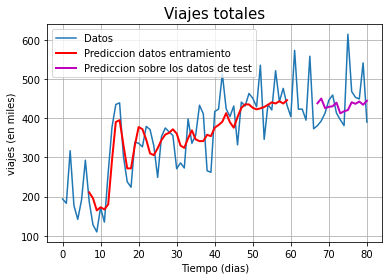

In [29]:
# predicciones del entrenamiento de cambio para plotear
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# predicciones del test de cambio para plotear
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2):len(dataset), :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
# ploteamos linea base y predicciones
plt.plot(trainPredictPlot,'r', linewidth = 2)
plt.plot(testPredictPlot,'m', linewidth = 2)
plt.legend( ('Datos', 'Prediccion datos entramiento', 'Prediccion sobre los datos de test'), loc = 'upper left')
plt.grid(True)
plt.title("Viajes totales", fontsize = 15)
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

In [30]:
results=testPredict
print(len(results))

14


In [31]:
testResults = testY_scalerInverse[0]

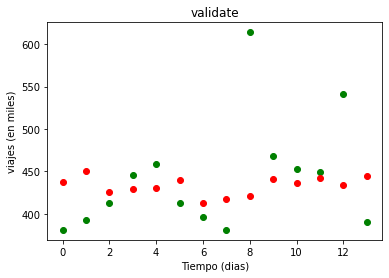

In [32]:
plt.scatter(range(len(testResults)),testResults,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('validate')
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.show()

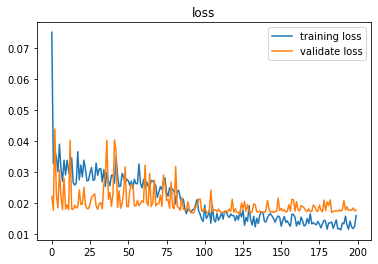

In [33]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('loss')
plt.legend( ('training loss', 'validate loss'), loc = 'upper right')
plt.show()

In [34]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$"):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bx", markersize=10)
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "ro")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])

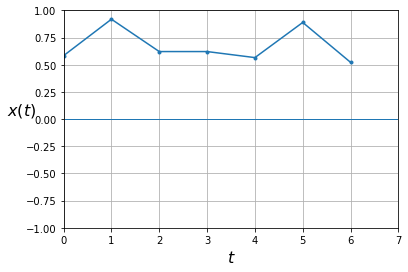

In [35]:
n_steps = 6 #preguntar
plot_series(testX[0, :, 0], testY_scalerInverse[0, 0], testPredict[0, 0])
plt.show()

# Exportar los datos

In [36]:
e_date = datetime.datetime.strptime('2020-06-20', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-06-07', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(testPredict, index= index_days)
prediccion.columns = ['valor predicho']

prediccion

,valor predicho
2020-06-07,437.958527
2020-06-08,449.998505
2020-06-09,425.761383
2020-06-10,428.813293
2020-06-11,430.491577
2020-06-12,439.618042
2020-06-13,412.409180
2020-06-14,417.553741
2020-06-15,420.698456
2020-06-16,440.523956


In [37]:
datosReales = df['2020-6-07':'2020-6-20']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-06-07,381,437.958527
2020-06-08,393,449.998505
2020-06-09,413,425.761383
2020-06-10,446,428.813293
2020-06-11,459,430.491577
2020-06-12,413,439.618042
2020-06-13,396,412.409180
2020-06-14,381,417.553741
2020-06-15,614,420.698456
2020-06-16,468,440.523956


In [38]:
compara.to_excel('Resultados INE.xlsx', columns=['real', 'prediccion'])

# Prediccion a futuro

In [39]:
# usaremos 7 dias que poseemos para predecir los 7 dias siguientes tras esto compararemos los resultados con los que
# poseemos para ver el grado de error

Dias = df['2020-5-25':'2020-5-31']

In [40]:
# funcion para convertir un array de valores en una matriz de conjuntos de datos, en este caso modificada para ayudarnos a crear
#los distintos sets de entrenmiento para distintos modelos que predeciran 1 dia cada uno

def create_dataset2(dataset, look_back=1, dias=0):
  dataX, dataY = [], []
  for i in range(len(dataset)-look_back-dias):
    a = dataset[i:(i+look_back), 0]
    dataX.append(a)
    dataY.append(dataset[i + look_back + dias, 0])
  return np.array(dataX), np.array(dataY)

In [41]:
#ahora crearemos los sets para entrenar los modelos
look_back = 7

trainX1, trainY1 = create_dataset2(train, look_back, 1)
testX1, testY1 = create_dataset2(test, look_back, 1)

trainX2, trainY2 = create_dataset2(train, look_back, 2)
testX2, testY2 = create_dataset2(test, look_back, 2)

trainX3, trainY3 = create_dataset2(train, look_back, 3)
testX3, testY3 = create_dataset2(test, look_back, 3)

trainX4, trainY4 = create_dataset2(train, look_back, 4)
testX4, testY4 = create_dataset2(test, look_back, 4)

trainX5, trainY5 = create_dataset2(train, look_back, 5)
testX5, testY5 = create_dataset2(test, look_back, 5)

trainX6, trainY6 = create_dataset2(train, look_back, 6)
testX6, testY6 = create_dataset2(test, look_back, 6)

In [42]:
print(trainX1)

[[0.16666667 0.14484127 0.41071433 0.13293652 0.06349207 0.16269843
  0.36309528]
 [0.14484127 0.41071433 0.13293652 0.06349207 0.16269843 0.36309528
  0.1547619 ]
 [0.41071433 0.13293652 0.06349207 0.16269843 0.36309528 0.1547619
  0.03571428]
 [0.13293652 0.06349207 0.16269843 0.36309528 0.1547619  0.03571428
  0.        ]
 [0.06349207 0.16269843 0.36309528 0.1547619  0.03571428 0.
  0.12301587]
 [0.16269843 0.36309528 0.1547619  0.03571428 0.         0.12301587
  0.04960318]
 [0.36309528 0.1547619  0.03571428 0.         0.12301587 0.04960318
  0.29960322]
 [0.1547619  0.03571428 0.         0.12301587 0.04960318 0.29960322
  0.52976197]
 [0.03571428 0.         0.12301587 0.04960318 0.29960322 0.52976197
  0.6448413 ]
 [0.         0.12301587 0.04960318 0.29960322 0.52976197 0.6448413
  0.65277785]
 [0.12301587 0.04960318 0.29960322 0.52976197 0.6448413  0.65277785
  0.38293654]
 [0.04960318 0.29960322 0.52976197 0.6448413  0.65277785 0.38293654
  0.25396824]
 [0.29960322 0.52976197 0.

In [43]:
print(trainY1)

[0.03571428 0.         0.12301587 0.04960318 0.29960322 0.52976197
 0.6448413  0.65277785 0.38293654 0.25396824 0.22619049 0.45436513
 0.44841272 0.43055558 0.5337302  0.5178572  0.43452382 0.27579367
 0.48214293 0.5257937  0.5059524  0.48809528 0.31944448 0.3492064
 0.32341272 0.5714286  0.44841272 0.4900794  0.6408731  0.59722227
 0.30952382 0.30158734 0.60912704 0.6210318  0.7996032  0.62301594
 0.5833334  0.63690484 0.44047624 0.6567461  0.63690484 0.7003969
 0.67658734 0.63293654 0.84325397 0.46825403 0.6448413  0.6170635
 0.8154763  0.6587302  0.7261905  0.6408731 ]


In [44]:
# remodelamos la entrada para que sea[muestras, pasos de tiempo, características]

trainX1 = np.reshape(trainX1, (trainX1.shape[0], trainX1.shape[1], 1))
testX1 = np.reshape(testX1, (testX1.shape[0], testX1.shape[1], 1))

trainX2 = np.reshape(trainX2, (trainX2.shape[0], trainX2.shape[1], 1))
testX2 = np.reshape(testX2, (testX2.shape[0], testX2.shape[1], 1))

trainX3 = np.reshape(trainX3, (trainX3.shape[0], trainX3.shape[1], 1))
testX3 = np.reshape(testX3, (testX3.shape[0], testX3.shape[1], 1))

trainX4 = np.reshape(trainX4, (trainX4.shape[0], trainX4.shape[1], 1))
testX4 = np.reshape(testX4, (testX4.shape[0], testX4.shape[1], 1))

trainX5 = np.reshape(trainX5, (trainX5.shape[0], trainX5.shape[1], 1))
testX5 = np.reshape(testX5, (testX5.shape[0], testX5.shape[1], 1))

trainX6 = np.reshape(trainX6, (trainX6.shape[0], trainX6.shape[1], 1))
testX6 = np.reshape(testX6, (testX6.shape[0], testX6.shape[1], 1))

In [45]:
#creamos los distintos modelos para predecir cada dia

model1 = crear_modeloFF()
history=model1.fit(trainX1, trainY1, epochs=200, validation_data=(testX1,testY1), batch_size=1, verbose=2)

model2 = crear_modeloFF()
history=model2.fit(trainX2, trainY2, epochs=200, validation_data=(testX2,testY2), batch_size=1, verbose=2)

model3 = crear_modeloFF()
history=model3.fit(trainX3, trainY3, epochs=200, validation_data=(testX3,testY3), batch_size=1, verbose=2)

model4 = crear_modeloFF()
history=model4.fit(trainX4, trainY4, epochs=200, validation_data=(testX4,testY4), batch_size=1, verbose=2)

model5 = crear_modeloFF()
history=model5.fit(trainX5, trainY5, epochs=200, validation_data=(testX5,testY5), batch_size=1, verbose=2)

model6 = crear_modeloFF()
history=model6.fit(trainX6, trainY6, epochs=200, validation_data=(testX6,testY6), batch_size=1, verbose=2)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 7, 20)             1760      
_________________________________________________________________
lstm_4 (LSTM)                (None, 7, 50)             14200     
_________________________________________________________________
dropout_2 (Dropout)          (None, 7, 50)             0         
_________________________________________________________________
lstm_5 (LSTM)                (None, 100)               60400     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 76,461
Trainable params: 76,461
Non-trainable params: 0
__________________________________________________

52/52 - 0s - loss: 0.0173 - val_loss: 0.0173
Epoch 123/200
52/52 - 0s - loss: 0.0157 - val_loss: 0.0173
Epoch 124/200
52/52 - 1s - loss: 0.0137 - val_loss: 0.0181
Epoch 125/200
52/52 - 0s - loss: 0.0144 - val_loss: 0.0174
Epoch 126/200
52/52 - 0s - loss: 0.0136 - val_loss: 0.0216
Epoch 127/200
52/52 - 0s - loss: 0.0155 - val_loss: 0.0226
Epoch 128/200
52/52 - 0s - loss: 0.0127 - val_loss: 0.0182
Epoch 129/200
52/52 - 0s - loss: 0.0121 - val_loss: 0.0169
Epoch 130/200
52/52 - 0s - loss: 0.0140 - val_loss: 0.0187
Epoch 131/200
52/52 - 0s - loss: 0.0124 - val_loss: 0.0174
Epoch 132/200
52/52 - 0s - loss: 0.0170 - val_loss: 0.0175
Epoch 133/200
52/52 - 0s - loss: 0.0155 - val_loss: 0.0206
Epoch 134/200
52/52 - 0s - loss: 0.0125 - val_loss: 0.0172
Epoch 135/200
52/52 - 0s - loss: 0.0135 - val_loss: 0.0175
Epoch 136/200
52/52 - 0s - loss: 0.0128 - val_loss: 0.0225
Epoch 137/200
52/52 - 0s - loss: 0.0145 - val_loss: 0.0171
Epoch 138/200
52/52 - 0s - loss: 0.0113 - val_loss: 0.0175
Epoch 139/2

Epoch 43/200
51/51 - 0s - loss: 0.0214 - val_loss: 0.0233
Epoch 44/200
51/51 - 0s - loss: 0.0217 - val_loss: 0.0211
Epoch 45/200
51/51 - 0s - loss: 0.0258 - val_loss: 0.0228
Epoch 46/200
51/51 - 0s - loss: 0.0252 - val_loss: 0.0232
Epoch 47/200
51/51 - 0s - loss: 0.0240 - val_loss: 0.0262
Epoch 48/200
51/51 - 0s - loss: 0.0216 - val_loss: 0.0228
Epoch 49/200
51/51 - 0s - loss: 0.0226 - val_loss: 0.0276
Epoch 50/200
51/51 - 0s - loss: 0.0198 - val_loss: 0.0213
Epoch 51/200
51/51 - 0s - loss: 0.0228 - val_loss: 0.0209
Epoch 52/200
51/51 - 0s - loss: 0.0216 - val_loss: 0.0223
Epoch 53/200
51/51 - 0s - loss: 0.0232 - val_loss: 0.0302
Epoch 54/200
51/51 - 0s - loss: 0.0235 - val_loss: 0.0312
Epoch 55/200
51/51 - 0s - loss: 0.0263 - val_loss: 0.0233
Epoch 56/200
51/51 - 0s - loss: 0.0214 - val_loss: 0.0331
Epoch 57/200
51/51 - 0s - loss: 0.0193 - val_loss: 0.0284
Epoch 58/200
51/51 - 0s - loss: 0.0236 - val_loss: 0.0217
Epoch 59/200
51/51 - 0s - loss: 0.0225 - val_loss: 0.0289
Epoch 60/200
5

Epoch 183/200
51/51 - 0s - loss: 0.0119 - val_loss: 0.0210
Epoch 184/200
51/51 - 0s - loss: 0.0121 - val_loss: 0.0262
Epoch 185/200
51/51 - 0s - loss: 0.0126 - val_loss: 0.0227
Epoch 186/200
51/51 - 0s - loss: 0.0123 - val_loss: 0.0206
Epoch 187/200
51/51 - 0s - loss: 0.0134 - val_loss: 0.0215
Epoch 188/200
51/51 - 0s - loss: 0.0118 - val_loss: 0.0215
Epoch 189/200
51/51 - 0s - loss: 0.0100 - val_loss: 0.0238
Epoch 190/200
51/51 - 0s - loss: 0.0118 - val_loss: 0.0199
Epoch 191/200
51/51 - 0s - loss: 0.0108 - val_loss: 0.0197
Epoch 192/200
51/51 - 0s - loss: 0.0095 - val_loss: 0.0190
Epoch 193/200
51/51 - 0s - loss: 0.0136 - val_loss: 0.0207
Epoch 194/200
51/51 - 0s - loss: 0.0131 - val_loss: 0.0197
Epoch 195/200
51/51 - 0s - loss: 0.0108 - val_loss: 0.0203
Epoch 196/200
51/51 - 0s - loss: 0.0141 - val_loss: 0.0193
Epoch 197/200
51/51 - 0s - loss: 0.0119 - val_loss: 0.0190
Epoch 198/200
51/51 - 0s - loss: 0.0103 - val_loss: 0.0192
Epoch 199/200
51/51 - 0s - loss: 0.0094 - val_loss: 0.01

50/50 - 0s - loss: 0.0176 - val_loss: 0.0212
Epoch 105/200
50/50 - 0s - loss: 0.0198 - val_loss: 0.0215
Epoch 106/200
50/50 - 0s - loss: 0.0172 - val_loss: 0.0292
Epoch 107/200
50/50 - 0s - loss: 0.0204 - val_loss: 0.0230
Epoch 108/200
50/50 - 0s - loss: 0.0168 - val_loss: 0.0219
Epoch 109/200
50/50 - 0s - loss: 0.0171 - val_loss: 0.0223
Epoch 110/200
50/50 - 0s - loss: 0.0196 - val_loss: 0.0212
Epoch 111/200
50/50 - 0s - loss: 0.0196 - val_loss: 0.0212
Epoch 112/200
50/50 - 0s - loss: 0.0158 - val_loss: 0.0250
Epoch 113/200
50/50 - 0s - loss: 0.0135 - val_loss: 0.0290
Epoch 114/200
50/50 - 0s - loss: 0.0189 - val_loss: 0.0236
Epoch 115/200
50/50 - 0s - loss: 0.0192 - val_loss: 0.0222
Epoch 116/200
50/50 - 0s - loss: 0.0183 - val_loss: 0.0210
Epoch 117/200
50/50 - 0s - loss: 0.0179 - val_loss: 0.0222
Epoch 118/200
50/50 - 0s - loss: 0.0178 - val_loss: 0.0216
Epoch 119/200
50/50 - 0s - loss: 0.0165 - val_loss: 0.0252
Epoch 120/200
50/50 - 0s - loss: 0.0151 - val_loss: 0.0226
Epoch 121/2

49/49 - 0s - loss: 0.0267 - val_loss: 0.0400
Epoch 25/200
49/49 - 0s - loss: 0.0223 - val_loss: 0.0372
Epoch 26/200
49/49 - 0s - loss: 0.0281 - val_loss: 0.0205
Epoch 27/200
49/49 - 0s - loss: 0.0232 - val_loss: 0.0416
Epoch 28/200
49/49 - 0s - loss: 0.0202 - val_loss: 0.0329
Epoch 29/200
49/49 - 0s - loss: 0.0225 - val_loss: 0.0206
Epoch 30/200
49/49 - 0s - loss: 0.0217 - val_loss: 0.0431
Epoch 31/200
49/49 - 0s - loss: 0.0261 - val_loss: 0.0267
Epoch 32/200
49/49 - 0s - loss: 0.0192 - val_loss: 0.0216
Epoch 33/200
49/49 - 0s - loss: 0.0270 - val_loss: 0.0211
Epoch 34/200
49/49 - 0s - loss: 0.0250 - val_loss: 0.0219
Epoch 35/200
49/49 - 0s - loss: 0.0232 - val_loss: 0.0476
Epoch 36/200
49/49 - 0s - loss: 0.0216 - val_loss: 0.0214
Epoch 37/200
49/49 - 0s - loss: 0.0224 - val_loss: 0.0209
Epoch 38/200
49/49 - 0s - loss: 0.0209 - val_loss: 0.0210
Epoch 39/200
49/49 - 0s - loss: 0.0240 - val_loss: 0.0285
Epoch 40/200
49/49 - 0s - loss: 0.0208 - val_loss: 0.0235
Epoch 41/200
49/49 - 0s - l

Epoch 165/200
49/49 - 0s - loss: 0.0124 - val_loss: 0.0212
Epoch 166/200
49/49 - 0s - loss: 0.0123 - val_loss: 0.0213
Epoch 167/200
49/49 - 0s - loss: 0.0146 - val_loss: 0.0246
Epoch 168/200
49/49 - 0s - loss: 0.0098 - val_loss: 0.0221
Epoch 169/200
49/49 - 0s - loss: 0.0095 - val_loss: 0.0246
Epoch 170/200
49/49 - 0s - loss: 0.0121 - val_loss: 0.0219
Epoch 171/200
49/49 - 0s - loss: 0.0122 - val_loss: 0.0230
Epoch 172/200
49/49 - 0s - loss: 0.0114 - val_loss: 0.0251
Epoch 173/200
49/49 - 0s - loss: 0.0145 - val_loss: 0.0211
Epoch 174/200
49/49 - 0s - loss: 0.0115 - val_loss: 0.0228
Epoch 175/200
49/49 - 0s - loss: 0.0117 - val_loss: 0.0245
Epoch 176/200
49/49 - 0s - loss: 0.0130 - val_loss: 0.0217
Epoch 177/200
49/49 - 0s - loss: 0.0109 - val_loss: 0.0213
Epoch 178/200
49/49 - 0s - loss: 0.0111 - val_loss: 0.0211
Epoch 179/200
49/49 - 0s - loss: 0.0136 - val_loss: 0.0249
Epoch 180/200
49/49 - 0s - loss: 0.0109 - val_loss: 0.0208
Epoch 181/200
49/49 - 0s - loss: 0.0143 - val_loss: 0.02

Epoch 86/200
48/48 - 0s - loss: 0.0152 - val_loss: 0.0339
Epoch 87/200
48/48 - 0s - loss: 0.0173 - val_loss: 0.0249
Epoch 88/200
48/48 - 0s - loss: 0.0178 - val_loss: 0.0252
Epoch 89/200
48/48 - 0s - loss: 0.0167 - val_loss: 0.0335
Epoch 90/200
48/48 - 0s - loss: 0.0151 - val_loss: 0.0370
Epoch 91/200
48/48 - 0s - loss: 0.0147 - val_loss: 0.0379
Epoch 92/200
48/48 - 0s - loss: 0.0169 - val_loss: 0.0279
Epoch 93/200
48/48 - 0s - loss: 0.0166 - val_loss: 0.0338
Epoch 94/200
48/48 - 0s - loss: 0.0157 - val_loss: 0.0310
Epoch 95/200
48/48 - 0s - loss: 0.0166 - val_loss: 0.0252
Epoch 96/200
48/48 - 0s - loss: 0.0173 - val_loss: 0.0348
Epoch 97/200
48/48 - 0s - loss: 0.0181 - val_loss: 0.0251
Epoch 98/200
48/48 - 0s - loss: 0.0173 - val_loss: 0.0266
Epoch 99/200
48/48 - 0s - loss: 0.0164 - val_loss: 0.0257
Epoch 100/200
48/48 - 0s - loss: 0.0158 - val_loss: 0.0254
Epoch 101/200
48/48 - 0s - loss: 0.0145 - val_loss: 0.0257
Epoch 102/200
48/48 - 0s - loss: 0.0180 - val_loss: 0.0383
Epoch 103/2

Epoch 6/200
47/47 - 0s - loss: 0.0242 - val_loss: 0.0821
Epoch 7/200
47/47 - 0s - loss: 0.0294 - val_loss: 0.0276
Epoch 8/200
47/47 - 0s - loss: 0.0260 - val_loss: 0.0361
Epoch 9/200
47/47 - 0s - loss: 0.0236 - val_loss: 0.0375
Epoch 10/200
47/47 - 0s - loss: 0.0250 - val_loss: 0.0255
Epoch 11/200
47/47 - 0s - loss: 0.0220 - val_loss: 0.0374
Epoch 12/200
47/47 - 0s - loss: 0.0184 - val_loss: 0.0360
Epoch 13/200
47/47 - 0s - loss: 0.0205 - val_loss: 0.0755
Epoch 14/200
47/47 - 0s - loss: 0.0250 - val_loss: 0.0529
Epoch 15/200
47/47 - 0s - loss: 0.0254 - val_loss: 0.0269
Epoch 16/200
47/47 - 0s - loss: 0.0258 - val_loss: 0.0256
Epoch 17/200
47/47 - 0s - loss: 0.0260 - val_loss: 0.0251
Epoch 18/200
47/47 - 0s - loss: 0.0248 - val_loss: 0.0249
Epoch 19/200
47/47 - 0s - loss: 0.0225 - val_loss: 0.0440
Epoch 20/200
47/47 - 0s - loss: 0.0247 - val_loss: 0.0709
Epoch 21/200
47/47 - 0s - loss: 0.0265 - val_loss: 0.0607
Epoch 22/200
47/47 - 0s - loss: 0.0275 - val_loss: 0.0511
Epoch 23/200
47/47

Epoch 147/200
47/47 - 0s - loss: 0.0151 - val_loss: 0.0262
Epoch 148/200
47/47 - 0s - loss: 0.0139 - val_loss: 0.0330
Epoch 149/200
47/47 - 0s - loss: 0.0119 - val_loss: 0.0275
Epoch 150/200
47/47 - 0s - loss: 0.0115 - val_loss: 0.0279
Epoch 151/200
47/47 - 0s - loss: 0.0132 - val_loss: 0.0272
Epoch 152/200
47/47 - 0s - loss: 0.0112 - val_loss: 0.0291
Epoch 153/200
47/47 - 0s - loss: 0.0125 - val_loss: 0.0307
Epoch 154/200
47/47 - 0s - loss: 0.0117 - val_loss: 0.0261
Epoch 155/200
47/47 - 0s - loss: 0.0129 - val_loss: 0.0294
Epoch 156/200
47/47 - 0s - loss: 0.0117 - val_loss: 0.0346
Epoch 157/200
47/47 - 0s - loss: 0.0115 - val_loss: 0.0267
Epoch 158/200
47/47 - 0s - loss: 0.0134 - val_loss: 0.0271
Epoch 159/200
47/47 - 0s - loss: 0.0125 - val_loss: 0.0259
Epoch 160/200
47/47 - 0s - loss: 0.0116 - val_loss: 0.0298
Epoch 161/200
47/47 - 0s - loss: 0.0135 - val_loss: 0.0293
Epoch 162/200
47/47 - 0s - loss: 0.0132 - val_loss: 0.0290
Epoch 163/200
47/47 - 0s - loss: 0.0108 - val_loss: 0.03

# Preparamos los datos para el test

In [46]:
# cargamos el dataframe en la variable dataset
dataset = Dias.values

# convertimos los enteros en floats
dataset = dataset.astype('float32')

# normalizamos los datos
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

In [47]:
#remodelamos los datos
testX = np.reshape(dataset, (1, 7, 1))

# Predicciones para la proxima semana

In [48]:
results = []

parcial=model.predict(testX)
results.append(parcial[0])

parcial=model1.predict(testX)
results.append(parcial[0])

parcial=model2.predict(testX)
results.append(parcial[0])

parcial=model3.predict(testX)
results.append(parcial[0])

parcial=model4.predict(testX)
results.append(parcial[0])

parcial=model5.predict(testX)
results.append(parcial[0])

parcial=model6.predict(testX)
results.append(parcial[0])

results = np.reshape(results, (7, 1))
print(results)

[[0.31919083]
 [0.4755804 ]
 [0.47931588]
 [0.5426111 ]
 [0.5958117 ]
 [0.48963568]
 [0.11829276]]


# Re-Convertimos los resultados

In [49]:
inverted = scaler.inverse_transform(results)

#en nuestro problema no tienen sentido los decimales pues no se pueden hacer 0.5 viajes o 0.25 viajes
inverted = inverted.round()
inverted = inverted.astype(int)

inverted

array([[441],
       [460],
       [460],
       [467],
       [474],
       [461],
       [418]])

# Visualizamos el pronostico

<AxesSubplot:>

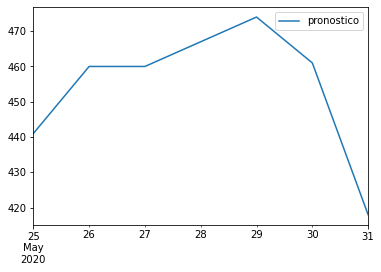

In [50]:
e_date = datetime.datetime.strptime('2020-05-31', '%Y-%m-%d')
i_date = datetime.datetime.strptime('2020-05-25', '%Y-%m-%d')
delta = e_date - i_date

index_days = []
for i in range(delta.days + 1):
    day = i_date + timedelta(days=i)
    index_days.append(day)

prediccion = pd.DataFrame(inverted, index= index_days)
prediccion.columns = ['pronostico']
prediccion.plot()

In [51]:
datosReales = df['2020-5-25':'2020-5-31']

compara = pd.concat([datosReales, prediccion], axis=1)
compara.columns = ['real', 'prediccion']

compara

,real,prediccion
2020-05-25,435,441
2020-05-26,421,460
2020-05-27,521,460
2020-05-28,442,467
2020-05-29,476,474
2020-05-30,433,461
2020-05-31,404,418


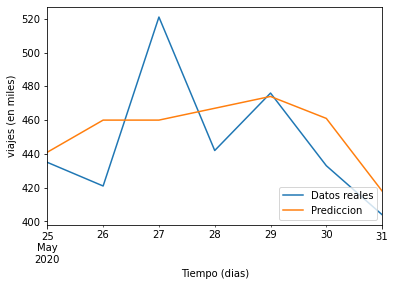

In [52]:
compara['real'].plot()
compara['prediccion'].plot()
plt.xlabel("Tiempo (dias)", fontsize = 10)
plt.ylabel("viajes (en miles)", fontsize = 10)
plt.legend( ('Datos reales', 'Prediccion'), loc = 'lower right')

In [53]:
# calculamos las metricas de error
testScore_MAE, testScore_MSE, testScore_RMSE, testScore_CVRMSE, testScore_MAPE  =  compute_metrics_fn(prediccion, datosReales)
print('Resultado del test: %.2f MAE' % (testScore_MAE))
print('Resultado del test: %.2f MSE' % (testScore_MSE))
print('Resultado del test: %.2f RMSE' % (testScore_RMSE))
print('Resultado del test: %.2f CVRMSE' % (testScore_CVRMSE))
print('Resultado del test: %.2f MAPE' % (testScore_MAPE))

Resultado del test: 25.00 MAE
Resultado del test: 983.86 MSE
Resultado del test: 31.37 RMSE
Resultado del test: 6.90 CVRMSE
Resultado del test: 5.47 MAPE
